# Big Data Technologies @ UCP

Welcome to this hands-on class on building Big Data applications using Spark components for batch processing.

This Jupyter Notebook exemplifies how to:
- [install PySpark](#install_pyspark)
- [download data](#download_data)
- [start PySpark cluster](#start_cluster)
- [perform RDD operations](#rdd)
- [perform Dataframe operations](#dataframe)
- [solve a "real" challenge](#challenge)

# Licensing

*The source code in this notebook is licensed under the* [*Apache License, Version 2.0*](https://www.apache.org/licenses/LICENSE-2.0).

*This notebook is licensed under the* [*Creative Commons Attribution-NonCommercial-ShareAlike 4.0 License*](https://creativecommons.org/licenses/by-nc-sa/4.0).

Developed by [*Miguel Costa*](https://www.linkedin.com/in/migcosta/)

<a name="install_pyspark"></a>
#PySpark Installation

In [2]:
# install pyspark
!pip install pyspark --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


<a name="download_data"></a>
# Download Data

In [3]:
# Moby-Dick eBook from The Project Gutenberg
EBOOK_FILE = '2701-0.txt'
EBOOK_URL = 'https://www.gutenberg.org/files/2701/' + EBOOK_FILE

In [4]:
# download file
!wget {EBOOK_URL}

--2024-05-17 17:00:33--  https://www.gutenberg.org/files/2701/2701-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1276235 (1.2M) [text/plain]
Saving to: ‘2701-0.txt’

2701-0.txt          100%[===================>]   1.22M  3.39MB/s    in 0.4s    

2024-05-17 17:00:34 (3.39 MB/s) - ‘2701-0.txt’ saved [1276235/1276235]



<a name="start_cluster"></a>
# Start PySpark Cluster

In [5]:
# start pyspark cluster in standalone mode
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

spark = SparkSession.builder\
          .appName("firstSparkApp")\
          .master('local[*]').getOrCreate()
sc = spark.sparkContext
spark

<a name="rdd"></a>
# RDD Operations

### Basics

In [6]:
# create an RDD
arr = sc.parallelize([1, 2, 3])

In [7]:
# retrieve RDD content
arr.collect()

[1, 2, 3]

In [8]:
# retrieve first 2 elements
arr.take(2)

[1, 2]

In [9]:
# count number of elements
arr.count()

3

In [10]:
# reduces elements with a commutative and associative function
arr.reduce(lambda x, y: x + y)

6

In [11]:
# pass each element through a lambda function
squares = arr.map(lambda x: x * x)
print(squares.collect())

[1, 4, 9]


In [12]:
# filter elements with a lambda function
even = squares.filter(lambda x: x % 2 == 0)
print(even.collect())

[4]


In [13]:
# passing function (len of each list) to run on the cluster
def myFunc(arr):
  return len(arr)

arr = sc.parallelize([[1],[1,1],[1,1,1]])
arr.map(myFunc).collect()

[1, 2, 3]

### Word Count

In [14]:
# count number of lines with the word Moby using the wc and grep commands
!grep Moby {EBOOK_FILE} | wc -l

83


In [15]:
# count number of lines and the lines containing the word Moby
rdd = sc.textFile(EBOOK_FILE) # read file to RDD
print(rdd.count())
print(rdd.filter(lambda s: "Moby" in s).count())

22316
83


In [16]:
# word count
result = rdd.flatMap(lambda line: line.lower().split(" "))\
    .filter(lambda word: word != '')\
    .map(lambda word: (word, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .sortBy(lambda x: x[1], ascending=False)
print(*result.take(10), sep='\n')

('the', 14512)
('of', 6683)
('and', 6322)
('a', 4663)
('to', 4599)
('in', 4126)
('that', 2748)
('his', 2485)
('it', 1777)
('with', 1750)


In [17]:
# save result to text file
result.saveAsTextFile("wordCount")
!ls wordCount
!head -n 10 wordCount/part-00000

part-00000  part-00001	_SUCCESS
('the', 14512)
('of', 6683)
('and', 6322)
('a', 4663)
('to', 4599)
('in', 4126)
('that', 2748)
('his', 2485)
('it', 1777)
('with', 1750)


### Total Words

In [18]:
# count total number of words  with the wc command
!wc -w {EBOOK_FILE}

215864 2701-0.txt


In [19]:
# count total number of words
rdd = sc.textFile(EBOOK_FILE) # read file to RDD
result = rdd.flatMap(lambda line: line.split(" "))\
      .filter(lambda word: word != '')\
      .map(lambda word: 1)\
      .reduce(lambda x, y: x + y)
print(result)

215864


<a name="dataframe"></a>
# DataFrame Operations

### Basics

In [20]:
from pyspark.sql import functions as f
from pyspark.sql.types import *

In [21]:
# list of tuples
col_values = [('Alice', 33, 151),
              ('Mary',  44, None),
              ('Joan',  55, 983)]

In [22]:
# create a DataFrame without an explicit schema
df = spark.createDataFrame(col_values)
df.show()

+-----+---+----+
|   _1| _2|  _3|
+-----+---+----+
|Alice| 33| 151|
| Mary| 44|NULL|
| Joan| 55| 983|
+-----+---+----+



In [23]:
# create a DataFrame without an explicit schema but with column names
df = spark.createDataFrame(col_values, schema=["name","age","code"])
df.show()

+-----+---+----+
| name|age|code|
+-----+---+----+
|Alice| 33| 151|
| Mary| 44|NULL|
| Joan| 55| 983|
+-----+---+----+



In [24]:
# print schema of DataFrame
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)
 |-- code: long (nullable = true)



In [25]:
# create a DataFrame with an explicit schema
schema = StructType([
             StructField("name", StringType(), True),
             StructField("age", IntegerType(), True),
             StructField("code", IntegerType(), True)
          ])

df = spark.createDataFrame(col_values, schema)
df.show()

+-----+---+----+
| name|age|code|
+-----+---+----+
|Alice| 33| 151|
| Mary| 44|NULL|
| Joan| 55| 983|
+-----+---+----+



In [26]:
# print schema of DataFrame
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- code: integer (nullable = true)



In [27]:
# print schema information
print(df.columns)
print(df.dtypes)

['name', 'age', 'code']
[('name', 'string'), ('age', 'int'), ('code', 'int')]


In [28]:
# collect the distributed dataframe from all worker nodes to the driver side
df.collect()

[Row(name='Alice', age=33, code=151),
 Row(name='Mary', age=44, code=None),
 Row(name='Joan', age=55, code=983)]

In [29]:
# collet the attribute name of second row
df.collect()[1]['name']

'Mary'

In [30]:
# collect column 'name'
[str(row['name']) for row in df.select('name').collect()]

['Alice', 'Mary', 'Joan']

In [31]:
# collect the first row
df.take(1)

[Row(name='Alice', age=33, code=151)]

In [32]:
# converto to pandas dataframe
df.toPandas()

,name,age,code
0,Alice,33,151.0
1,Mary,44,NaN
2,Joan,55,983.0


In [33]:
# describe some summary statistics of DataFrame
df.describe().show()

+-------+-----+----+-----------------+
|summary| name| age|             code|
+-------+-----+----+-----------------+
|  count|    3|   3|                2|
|   mean| NULL|44.0|            567.0|
| stddev| NULL|11.0|588.3128419472075|
|    min|Alice|  33|              151|
|    max| Mary|  55|              983|
+-------+-----+----+-----------------+



### Word Count

In [34]:
# count number of lines and number of lines containing the word Moby
df = spark.read.text(EBOOK_FILE) # read file to DataFrame
print(df.count())
print(df.filter(f.col("value").contains("Moby")).count())
print(df.filter(df.value.contains("Moby")).count()) # equal to the previous line

22316
83
83


In [35]:
# word count - with withColumn
df.withColumn('word', f.explode(f.split(f.lower(f.col('value')), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show(10)

+----+-----+
|word|count|
+----+-----+
| the|14512|
|  of| 6683|
| and| 6322|
|   a| 4663|
|  to| 4599|
|  in| 4126|
|    | 4119|
|that| 2748|
| his| 2485|
|  it| 1777|
+----+-----+
only showing top 10 rows



In [36]:
# word count - with select
df.select(f.explode(f.split(f.lower(f.col('value')), ' ')).alias("word"))\
    .groupBy('word')\
    .count()\
    .orderBy(f.col('count').desc())\
    .show(10)

+----+-----+
|word|count|
+----+-----+
| the|14512|
|  of| 6683|
| and| 6322|
|   a| 4663|
|  to| 4599|
|  in| 4126|
|    | 4119|
|that| 2748|
| his| 2485|
|  it| 1777|
+----+-----+
only showing top 10 rows



### Total Words

In [37]:
# count total number of words
df.select(f.explode(f.split(f.col('value'), ' ')).alias("word"))\
    .filter(f.col('word')!='')\
    .count()

215864

### Using UDF

In [38]:
import pandas as pd
from pyspark.sql.functions import pandas_udf

In [39]:
# create dataframe
df = spark.createDataFrame(col_values, schema)
df.show()

+-----+---+----+
| name|age|code|
+-----+---+----+
|Alice| 33| 151|
| Mary| 44|NULL|
| Joan| 55| 983|
+-----+---+----+



In [40]:
# create a function
def square(x):
    return int(x**2)

# convert function to UDF function
square_udf = f.udf(lambda a: square(a), IntegerType())

# apply function
df.select('age', square_udf('age').alias('square_age')).show()

+---+----------+
|age|square_age|
+---+----------+
| 33|      1089|
| 44|      1936|
| 55|      3025|
+---+----------+



In [41]:
# create an UDF function using annotation syntax
#@f.udf(returnType=IntegerType())
@f.udf('int')
def len_udf(s):
    return len(s)

# apply function
df.select('name', len_udf('name').alias('len_name')).show()

+-----+--------+
| name|len_name|
+-----+--------+
|Alice|       5|
| Mary|       4|
| Joan|       4|
+-----+--------+



### Using SQL

In [42]:
# register the dataframe as a SQL temporary view
df.createOrReplaceTempView("test_table")

# query view/dataframe
spark.sql("select * from test_table").show()

+-----+---+----+
| name|age|code|
+-----+---+----+
|Alice| 33| 151|
| Mary| 44|NULL|
| Joan| 55| 983|
+-----+---+----+



In [43]:
# query view/dataframe to count by name
spark.sql("select count(*), name from test_table group by name").show()

+--------+-----+
|count(1)| name|
+--------+-----+
|       1|Alice|
|       1| Mary|
|       1| Joan|
+--------+-----+



In [44]:
# query view/dataframe with aggregation functions
spark.sql("select AVG(age), MIN(age), MAX(age) from test_table where age>40").show()

+--------+--------+--------+
|avg(age)|min(age)|max(age)|
+--------+--------+--------+
|    49.5|      44|      55|
+--------+--------+--------+



In [45]:
# register udf function
spark.udf.register("square_udf", square_udf)

# query with udf function
spark.sql("select age, square_udf(age) from test_table").show()

+---+---------------+
|age|square_udf(age)|
+---+---------------+
| 33|           1089|
| 44|           1936|
| 55|           3025|
+---+---------------+



### Persistence & Query Optimization

In [46]:
# create DataFrame
df = spark.createDataFrame(col_values, schema)
df.show()

+-----+---+----+
| name|age|code|
+-----+---+----+
|Alice| 33| 151|
| Mary| 44|NULL|
| Joan| 55| 983|
+-----+---+----+



In [47]:
# determining whether it is cached
print("is cached = %s \n" % df.is_cached)

# prints the logical and physical plans
df.explain(True)

is cached = False 

== Parsed Logical Plan ==
LogicalRDD [name#554, age#555, code#556], false

== Analyzed Logical Plan ==
name: string, age: int, code: int
LogicalRDD [name#554, age#555, code#556], false

== Optimized Logical Plan ==
LogicalRDD [name#554, age#555, code#556], false

== Physical Plan ==
*(1) Scan ExistingRDD[name#554,age#555,code#556]



In [48]:
# apply some transformations, print the execution plans & see the optimizations (compare logical & pyshical plans)
df = df\
    .withColumn('age', f.col('age')+f.lit(1))\
    .filter(f.col('name')!='Mary')\
    .withColumn('age', f.col('age')*f.lit(2))
df.show()
df.explain(True)

+-----+---+----+
| name|age|code|
+-----+---+----+
|Alice| 68| 151|
| Joan|112| 983|
+-----+---+----+

== Parsed Logical Plan ==
'Project [name#554, ('age * 2) AS age#577, code#556]
+- Filter NOT (name#554 = Mary)
   +- Project [name#554, (age#555 + 1) AS age#573, code#556]
      +- LogicalRDD [name#554, age#555, code#556], false

== Analyzed Logical Plan ==
name: string, age: int, code: int
Project [name#554, (age#573 * 2) AS age#577, code#556]
+- Filter NOT (name#554 = Mary)
   +- Project [name#554, (age#555 + 1) AS age#573, code#556]
      +- LogicalRDD [name#554, age#555, code#556], false

== Optimized Logical Plan ==
Project [name#554, ((age#555 + 1) * 2) AS age#577, code#556]
+- Filter (isnotnull(name#554) AND NOT (name#554 = Mary))
   +- LogicalRDD [name#554, age#555, code#556], false

== Physical Plan ==
*(1) Project [name#554, ((age#555 + 1) * 2) AS age#577, code#556]
+- *(1) Filter (isnotnull(name#554) AND NOT (name#554 = Mary))
   +- *(1) Scan ExistingRDD[name#554,age#555,co

In [49]:
# cache dataframe
df.cache() # or df.persist(StorageLevel.MEMORY_ONLY)
df.count() # action to force cache
print("is cached = %s \n" % df.is_cached)

is cached = True 



In [50]:
# apply transformation & see that the execution plan uses the cache
df2 = df.withColumn('age', f.col('age')+f.lit(1))
df2.explain(True)

== Parsed Logical Plan ==
'Project [name#554, ('age + 1) AS age#692, code#556]
+- Project [name#554, (age#573 * 2) AS age#577, code#556]
   +- Filter NOT (name#554 = Mary)
      +- Project [name#554, (age#555 + 1) AS age#573, code#556]
         +- LogicalRDD [name#554, age#555, code#556], false

== Analyzed Logical Plan ==
name: string, age: int, code: int
Project [name#554, (age#577 + 1) AS age#692, code#556]
+- Project [name#554, (age#573 * 2) AS age#577, code#556]
   +- Filter NOT (name#554 = Mary)
      +- Project [name#554, (age#555 + 1) AS age#573, code#556]
         +- LogicalRDD [name#554, age#555, code#556], false

== Optimized Logical Plan ==
Project [name#554, (age#577 + 1) AS age#692, code#556]
+- InMemoryRelation [name#554, age#577, code#556], StorageLevel(disk, memory, deserialized, 1 replicas)
      +- *(1) Project [name#554, ((age#555 + 1) * 2) AS age#577, code#556]
         +- *(1) Filter (isnotnull(name#554) AND NOT (name#554 = Mary))
            +- *(1) Scan Existing

### Reading/Writing DataFrame to File

In [51]:
df.show()

+-----+---+----+
| name|age|code|
+-----+---+----+
|Alice| 68| 151|
| Joan|112| 983|
+-----+---+----+



In [52]:
# save dataframe to csv file
df.write.csv('dataframe.csv', header=True)
!cat dataframe.csv/*

name,age,code
Alice,68,151
name,age,code
Joan,112,983


In [53]:
# load dataframe from csv file
df2 = spark.read.csv('dataframe.csv', header=True).show()

+-----+---+----+
| name|age|code|
+-----+---+----+
| Joan|112| 983|
|Alice| 68| 151|
+-----+---+----+



In [54]:
# save dataframe to parquet file
df.write.parquet('dataframe.parquet')

In [55]:
# load dataframe from parquet file
df2 = spark.read.parquet('dataframe.parquet').show()

+-----+---+----+
| name|age|code|
+-----+---+----+
|Alice| 68| 151|
| Joan|112| 983|
+-----+---+----+



<a name="challenge"></a>
# Real Challenge

Example of a few operations to clean an prepare a dataset for Machine Learning algorithms using the New York City Airbnb Open Data dataset (https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/).
- AB_NYC_2019.csv contains 16 columns (id, name, host_id, host_name, ..., price)

# Hands-on Exercise: PySpark Feature Engineering

### Get & Describe Dataset

In [479]:
# download dataset
!wget https://raw.githubusercontent.com/malcosta/bigdatatechnologies/main/data/AB_NYC_2019.csv -O ~/AB_NYC_2019.csv

--2024-05-17 22:19:47--  https://raw.githubusercontent.com/malcosta/bigdatatechnologies/main/data/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘/root/AB_NYC_2019.csv’

/root/AB_NYC_2019.c 100%[===================>]   6.75M  --.-KB/s    in 0.05s   

2024-05-17 22:19:48 (124 MB/s) - ‘/root/AB_NYC_2019.csv’ saved [7077973/7077973]



In [557]:
# load dataframe from csv file
df = spark.read.csv('/root/AB_NYC_2019.csv', header=True)

# print dataset size
print("rows %d, columns %d " % (df.count(), len(df.columns)))

# print dataframe schema
df.printSchema()

rows 49079, columns 16 
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)



In [452]:
# describe dataset
# 'price' has strings in it, must remove those observations:
df.describe('price').show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             48894|
|   mean|152.22296299343384|
| stddev|238.54148640283228|
|    min|         -73.99986|
|    max|      Private room|
+-------+------------------+



### Clean

In [558]:
# count missing values - Nan or None
df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
| id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  0|  32|    185|      212|                185|          185|     185|      185|      185|  185|           185|              205|      10234|            10215|                           187|             342|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+----

In [559]:
# last_review and reviews_per_month have over 10k missing values, while the rest of the columns have just a few

# assign 0 to reviews_per_month
c = 'reviews_per_month'
df = df.withColumn(c, f.when(f.isnan(c) | f.col(c).isNull(), f.lit(0)).otherwise(f.col(c)))

# drop unused columns
df = df.drop(*['id','host_name','last_review'])

# drop rows that contains nulls
df = df.na.drop()

In [560]:
# removing irrelavant type in "room_type" and defining expected room types
expected_room_types = ['Shared room', 'Entire home/apt', 'Private room']

# Filter out rows with unexpected room types
df = df.filter(df['room_type'].isin(expected_room_types))

In [561]:
# Group by 'room_type' and count occurrences of each category
room_type_counts = df.groupBy('room_type').count()

# Show the category counts
room_type_counts.show()


+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room| 1157|
|Entire home/apt|25338|
|   Private room|22218|
+---------------+-----+



In [485]:
# describe dataset
df.describe().show()

+-------+-----------------------------+-------------------+-------------------+-------------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------------------+------------------+
|summary|                         name|            host_id|neighbourhood_group|neighbourhood|           latitude|          longitude|      room_type|             price|    minimum_nights| number_of_reviews| reviews_per_month|calculated_host_listings_count|  availability_365|
+-------+-----------------------------+-------------------+-------------------+-------------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------------------+------------------+
|  count|                        48713|              48713|              48713|        48713|              48713|              48713|          48713|             48713|    

In [562]:
from pyspark.sql.functions import col

# Check for strings in the 'price' column
contains_strings = df.filter(~col('price').cast('float').isNotNull()).count() > 0

if contains_strings:
    print("The 'price' column contains strings.")
else:
    print("The 'price' column does not contain any strings.")


The 'price' column does not contain any strings.


In [563]:
# check again missing values - Nan or None
df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|name|host_id|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|
+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|   0|      0|                  0|            0|       0|        0|        0|    0|             0|                0|                0|                             0|               0|
+----+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+



In [564]:
# dealing with outliers in the dataset:
from pyspark.sql.functions import stddev_samp, mean, col

# Define z-score threshold
threshold = 3

# Calculate z-scores for each numerical column
numeric_columns = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
for col_name in numeric_columns:
    # Calculate mean and standard deviation for the column
    mean_val = df.select(mean(col(col_name))).first()[0]
    stddev_val = df.select(stddev_samp(col(col_name))).first()[0]

    # Calculate z-score
    df = df.withColumn(col_name + '_z_score', (col(col_name) - mean_val) / stddev_val)

# Filter out rows where any z-score exceeds the threshold
for col_name in numeric_columns:
    df = df.filter((col(col_name + '_z_score') <= threshold) & (col(col_name + '_z_score') >= -threshold))

# Drop z-score columns
for col_name in numeric_columns:
    df = df.drop(col_name + '_z_score')

# Show the filtered DataFrame
df.show()


+--------------------+-------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|                name|host_id|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|
+--------------------+-------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+
|Clean & quiet apt...|   2787|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9|             0.21|                             6|             365|
|Skylit Midtown Ca...|   2845|          Manhattan|           Midtown|40.75362|-73.98377|Entire home/apt|  225|             1|               45|             0.38

In [538]:
df.describe().show()

+-------+-----------------------------+-------------------+-------------------+-------------+--------------------+-------------------+---------------+------------------+-----------------+------------------+------------------+------------------------------+------------------+
|summary|                         name|            host_id|neighbourhood_group|neighbourhood|            latitude|          longitude|      room_type|             price|   minimum_nights| number_of_reviews| reviews_per_month|calculated_host_listings_count|  availability_365|
+-------+-----------------------------+-------------------+-------------------+-------------+--------------------+-------------------+---------------+------------------+-----------------+------------------+------------------+------------------------------+------------------+
|  count|                        44305|              44305|              44305|        44305|               44305|              44305|          44305|             44305|   

In [463]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)



### Create Features

In [565]:
# create new columns/data features - neighborhood mean price and difference to the mean price
df_agg = df.groupBy('neighbourhood').agg(f.mean('price').alias('mean_price_neighbourhood'))
df = df.join(df_agg, 'neighbourhood', 'left')
df = df.withColumn('diff_price_neighbourhood', f.col('price')-f.col('mean_price_neighbourhood'))

In [147]:
df.select(['neighbourhood','price','mean_price_neighbourhood','diff_price_neighbourhood']).limit(5).toPandas()

,neighbourhood,price,mean_price_neighbourhood,diff_price_neighbourhood
0,Kensington,149,92.885714,56.114286
1,Midtown,225,282.783907,-57.783907
2,Harlem,150,119.114729,30.885271
3,Clinton Hill,89,182.045534,-93.045534
4,East Harlem,80,133.130396,-53.130396


In [566]:
# create new columns/data features - mean and sum of reviews for each host_id
df_agg = df.groupBy('host_id').agg(f.mean('number_of_reviews').alias('mean_number_of_reviews_host_id'), f.sum('number_of_reviews').alias('sum_number_of_reviews_host_id'))
df = df.join(df_agg, 'host_id', 'left')

In [201]:
df.select(['host_id','number_of_reviews','mean_number_of_reviews_host_id','sum_number_of_reviews_host_id']).limit(5).toPandas()

,host_id,number_of_reviews,mean_number_of_reviews_host_id,sum_number_of_reviews_host_id
0,2787,9,17.5,105.0
1,2845,45,23.0,46.0
2,4632,0,0.0,0.0
3,4869,270,270.0,270.0
4,7192,9,9.0,9.0


# Feature 1 : Location popularity
Determines the popularity of the neighbourhood based on the total number of listings in that neighborhood and the total number of listings for each host. More popular locations might command higher prices.

In [567]:

# Calculate the total host listings count by neighbourhood group
location_popularity = df.groupBy('neighbourhood_group').agg(f.sum('calculated_host_listings_count').alias('host_listings_count_by_neighbourhood_group'))

# Join the total host listings count with the original DataFrame
df = df.join(location_popularity, 'neighbourhood_group', 'left')

# Calculate location popularity as a proportion of total listings count
df = df.withColumn('location_popularity', f.col('calculated_host_listings_count') / f.col('host_listings_count_by_neighbourhood_group'))

# Apply log transformation to location_popularity
df = df.withColumn('location_popularity_log', f.log1p(df['location_popularity']))

# Apply power transformation (e.g., square root) to reduce distribution range
df = df.withColumn('location_popularity_transformed', f.sqrt(df['location_popularity_log']))

# Scale the values between 0 and 1 using min-max scaling
min_value = df.select(f.min('location_popularity_transformed')).collect()[0][0]
max_value = df.select(f.max('location_popularity_transformed')).collect()[0][0]
df = df.withColumn('location_popularity_scaled', (df['location_popularity_transformed'] - min_value) / (max_value - min_value))

# Create categories "high" and "low" based on location_popularity_scaled
df = df.withColumn('location_popularity_category',
                   f.when(df['location_popularity_scaled'] > 0.05, 'high')
                   .otherwise('low'))

# Drop intermediate columns
df.select('host_listings_count_by_neighbourhood_group',
             'location_popularity', 'location_popularity_log',
             'location_popularity_transformed', 'location_popularity_scaled')

# Show the DataFrame with the newly added category
#df.select('location_popularity_category').show()



DataFrame[host_listings_count_by_neighbourhood_group: double, location_popularity: double, location_popularity_log: double, location_popularity_transformed: double, location_popularity_scaled: double]

In [515]:
df.describe().show()

+-------+-------------------+-------------------+-------------+-----------------------------+--------------------+-------------------+---------------+------------------+-----------------+------------------+------------------+------------------------------+------------------+------------------------+------------------------+------------------------------+-----------------------------+------------------------------------------+--------------------+-----------------------+-------------------------------+--------------------------+----------------------------+
|summary|neighbourhood_group|            host_id|neighbourhood|                         name|            latitude|          longitude|      room_type|             price|   minimum_nights| number_of_reviews| reviews_per_month|calculated_host_listings_count|  availability_365|mean_price_neighbourhood|diff_price_neighbourhood|mean_number_of_reviews_host_id|sum_number_of_reviews_host_id|host_listings_count_by_neighbourhood_group| locatio

# Feature 2 : Host popularity
Based on the availability of the host, I decided their popularity. If they are available for less than 30 days in a year then the host is considered very popular among clients.  

In [568]:
# conditions for host popularity
condition_high = (f.col('availability_365') < 30)
condition_medium = (f.col('availability_365') > 30) & (f.col('availability_365') < 250)

# Create the new column 'host_popularity' based on conditions
df = df.withColumn('host_popularity', f.when(condition_high, 'low')
                                      .when(condition_medium, 'medium')
                                      .otherwise('high'))

# Show the updated DataFrame with the new 'host_popularity' column
df.limit(5).toPandas()

,neighbourhood_group,host_id,neighbourhood,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,diff_price_neighbourhood,mean_number_of_reviews_host_id,sum_number_of_reviews_host_id,host_listings_count_by_neighbourhood_group,location_popularity,location_popularity_log,location_popularity_transformed,location_popularity_scaled,location_popularity_category,host_popularity
0,Brooklyn,2787,Kensington,Clean & quiet apt home by the park,40.64749,-73.97237,Private room,149,1,9,...,55.476744,17.5,105.0,43465.0,0.000138,0.000138,0.011749,0.067065,high,high
1,Manhattan,2845,Midtown,Skylit Midtown Castle,40.75362,-73.98377,Entire home/apt,225,1,45,...,-37.016499,23.0,46.0,98665.0,0.000020,0.000020,0.004502,0.010325,low,high
2,Manhattan,4632,Harlem,THE VILLAGE OF HARLEM....NEW YORK !,40.80902,-73.9419,Private room,150,3,0,...,36.614927,0.0,0.0,98665.0,0.000010,0.000010,0.003184,0.000000,low,high
3,Manhattan,7192,East Harlem,Entire Apt: Spacious Studio/Loft by central park,40.79851,-73.94399,Entire home/apt,80,10,9,...,-41.138329,9.0,9.0,98665.0,0.000010,0.000010,0.003184,0.000000,low,low
4,Manhattan,7322,Murray Hill,Large Cozy 1 BR Apartment In Midtown East,40.74767,-73.975,Entire home/apt,200,3,74,...,-9.830508,74.0,74.0,98665.0,0.000010,0.000010,0.003184,0.000000,low,medium


# Feature 3 : Host Experience
Calculating a metric that represents the experience of the host based on the number of listings they have and the number of reviews they receive. This can indicate the reliability or attractiveness of the host's properties. Based on this I categorize them.



In [569]:
from pyspark.sql.functions import when
# Host experience factor
df = df.withColumn('host_experience_factor', f.log1p(df['calculated_host_listings_count'] * df['sum_number_of_reviews_host_id']))

# Categorize hosts based on host_experience_factor
df = df.withColumn('host_experience_category',
                   when(df['host_experience_factor'] <= 3.0, 'Low Experience')
                   .when(df['host_experience_factor'] >= 8.0, 'High Experience')
                   .otherwise('Medium Experience'))

df.limit(5).toPandas()


,neighbourhood_group,host_id,neighbourhood,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,sum_number_of_reviews_host_id,host_listings_count_by_neighbourhood_group,location_popularity,location_popularity_log,location_popularity_transformed,location_popularity_scaled,location_popularity_category,host_popularity,host_experience_factor,host_experience_category
0,Brooklyn,2787,Kensington,Clean & quiet apt home by the park,40.64749,-73.97237,Private room,149,1,9,...,105.0,43465.0,0.000138,0.000138,0.011749,0.067065,high,high,6.447306,Medium Experience
1,Manhattan,2845,Midtown,Skylit Midtown Castle,40.75362,-73.98377,Entire home/apt,225,1,45,...,46.0,98665.0,0.000020,0.000020,0.004502,0.010325,low,high,4.532599,Medium Experience
2,Manhattan,4632,Harlem,THE VILLAGE OF HARLEM....NEW YORK !,40.80902,-73.9419,Private room,150,3,0,...,0.0,98665.0,0.000010,0.000010,0.003184,0.000000,low,high,0.000000,Low Experience
3,Manhattan,7192,East Harlem,Entire Apt: Spacious Studio/Loft by central park,40.79851,-73.94399,Entire home/apt,80,10,9,...,9.0,98665.0,0.000010,0.000010,0.003184,0.000000,low,low,2.302585,Low Experience
4,Manhattan,7322,Murray Hill,Large Cozy 1 BR Apartment In Midtown East,40.74767,-73.975,Entire home/apt,200,3,74,...,74.0,98665.0,0.000010,0.000010,0.003184,0.000000,low,medium,4.317488,Medium Experience


In [382]:
# Describe the new column 'host_experience_factor'
df.describe().show()

+-------+-------------------+-------------------+-------------+-----------------------------+--------------------+-------------------+---------------+------------------+-----------------+------------------+------------------+------------------------------+------------------+------------------------+------------------------+------------------------------+-----------------------------+------------------------------------------+--------------------+-----------------------+-------------------------------+--------------------------+----------------------------+----------------------+------------------------+
|summary|neighbourhood_group|            host_id|neighbourhood|                         name|            latitude|          longitude|      room_type|             price|   minimum_nights| number_of_reviews| reviews_per_month|calculated_host_listings_count|  availability_365|mean_price_neighbourhood|diff_price_neighbourhood|mean_number_of_reviews_host_id|sum_number_of_reviews_host_id|hos

# Feature 4 : Booking density
Calculating the ratio of the number of reviews to the availability of the listing. Higher booking density might indicate high demand, influencing prices.

In [570]:
from pyspark.sql.functions import when

# Replace missing values in 'availability_365' column with 0
df = df.withColumn('availability_365', when(df['availability_365'].isNull(), 0).otherwise(df['availability_365']))

# Avoid division by zero by replacing 0 values in 'availability_365' with a small non-zero value
df = df.withColumn('availability_365', when(df['availability_365'] == 0, 1e-6).otherwise(df['availability_365']))

# Calculate 'booking_density' column
df = df.withColumn('booking_density', df['number_of_reviews'] / df['availability_365'])


# Feature 5 : Room Diversity
Measures the diversity of room types offered by hosts. Hosts offering a variety of room types might attract a wider range of guests and potentially charge higher prices.

In [571]:
# Room type diversity
room_type_diversity = df.groupBy('host_id').agg(f.countDistinct('room_type').alias('room_type_count'))
df = df.join(room_type_diversity, 'host_id', 'left')


In [572]:
df.describe().show()

+-------+-------------------+-------------------+-------------+-----------------------------+--------------------+-------------------+---------------+------------------+-----------------+------------------+------------------+------------------------------+------------------+------------------------+------------------------+------------------------------+-----------------------------+------------------------------------------+--------------------+-----------------------+-------------------------------+--------------------------+----------------------------+---------------+----------------------+------------------------+-----------------+------------------+
|summary|            host_id|neighbourhood_group|neighbourhood|                         name|            latitude|          longitude|      room_type|             price|   minimum_nights| number_of_reviews| reviews_per_month|calculated_host_listings_count|  availability_365|mean_price_neighbourhood|diff_price_neighbourhood|mean_number

In [574]:
# saving the dataset:
df.write.csv('output.csv')


### Price Prediction using Spark MLlib

In [575]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, VectorIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# define the features and label column names
label_col = 'price'

# cast features (enforce the right data type)
float_cols = ['reviews_per_month','mean_number_of_reviews_host_id','latitude','longitude','location_popularity_scaled','host_experience_factor','booking_density']
cat_cols = ['neighbourhood_group', 'room_type','host_experience_category','location_popularity_category','host_popularity','room_type_count']
int_cols = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'price']

for col in float_cols:
  df = df.withColumn(col, df[col].cast('float'))
for col in cat_cols:
  df = df.withColumn(col, df[col].cast('string'))
for col in int_cols:
  df = df.withColumn(col, df[col].cast('int'))
#df.printSchema()

# drop rows that contain nulls due to casts
df = df.na.drop()

# Convert categorical columns to numeric using one-hot encoding
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_index')
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col+'_vec'])
    df = indexer.fit(df).transform(df)
    df = encoder.fit(df).transform(df)

# Assemble the features into a vector
features_cols = int_cols + float_cols + [col+'_vec' for col in cat_cols]
features_cols = list(set(features_cols) - set([label_col])) # remove label from features

assembler = VectorAssembler(inputCols=features_cols, outputCol='unscaled_features')
dataset = assembler.transform(df.select(label_col, *features_cols))

# Apply StandardScaler to normalize features
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(dataset)
dataset = scaler_model.transform(dataset)

# Split the data into training (80%) and testing (20%) sets
train_dataset, test_dataset = dataset.randomSplit([0.8, 0.2], seed=333)

# Train a linear regression model
lr = LinearRegression(featuresCol='features', labelCol=label_col, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train_dataset)


In [522]:
dataset.limit(5).toPandas()


,price,number_of_reviews,mean_number_of_reviews_host_id,booking_density,host_experience_factor,location_popularity_category_vec,room_type_count_vec,room_type_vec,calculated_host_listings_count,neighbourhood_group_vec,host_experience_category_vec,location_popularity_scaled,host_popularity_vec,reviews_per_month,minimum_nights,unscaled_features,features
0,149,9,17.5,2.465753e-02,6.447306,(0.0),"(0.0, 1.0)","(0.0, 1.0)",6,"(0.0, 1.0, 0.0, 0.0)","(0.0, 1.0)",0.067065,"(0.0, 0.0)",0.21,1,"(9.0, 17.5, 0.024657534435391426, 6.4473056793...","[-0.30432266618428266, -0.016867390944651214, ..."
1,225,45,23.0,1.267606e-01,4.532599,(1.0),"(0.0, 1.0)","(1.0, 0.0)",2,"(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)",0.010325,"(0.0, 0.0)",0.38,1,"[45.0, 23.0, 0.1267605572938919, 4.53259944915...","[0.9167929327415195, 0.17976014417480732, -0.2..."
2,150,0,0.0,0.000000e+00,0.000000,(1.0),"(1.0, 0.0)","(0.0, 1.0)",1,"(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)",0.000000,"(0.0, 0.0)",0.00,3,"(0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...","[-0.6096015659157332, -0.6425004572338374, -0...."
3,80,9,9.0,9.000000e+06,2.302585,(1.0),"(1.0, 0.0)","(1.0, 0.0)",1,"(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)",0.000000,"(1.0, 0.0)",0.10,10,"[9.0, 9.0, 9000000.0, 2.3025851249694824, 1.0,...","[-0.30432266618428266, -0.32074630885654165, 0..."
4,200,74,74.0,5.736434e-01,4.317488,(1.0),"(1.0, 0.0)","(1.0, 0.0)",1,"(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)",0.000000,"(0.0, 1.0)",0.59,3,"[74.0, 74.0, 0.5736433863639832, 4.31748819351...","[1.900469387431749, 2.0030336516461498, -0.275..."


In [547]:
dataset.select(['features']).limit(5).toPandas()

,features
0,"[-0.30432266618428266, -0.016867390944651214, ..."
1,"[0.9167929327415195, 0.17976014417480732, -0.2..."
2,"[-0.6096015659157332, -0.6425004572338374, -0...."
3,"[-0.30432266618428266, -0.32074630885654165, 0..."
4,"[1.900469387431749, 2.0030336516461498, -0.275..."


In [576]:
# make predictions on the test data
predictions = model.transform(test_dataset)
predictions.select("prediction", label_col, "features").show(5)

+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
| 44.46574425713885|    0|[-0.2753521649418...|
|106.33554187001423|   10|[-0.2753522059616...|
| 47.24323995664787|   10|[-0.2753522059616...|
| 165.2193438333536|   10|[-0.2753519148288...|
|116.02721341996808|   10|[-0.0750027766033...|
+------------------+-----+--------------------+
only showing top 5 rows



In [577]:
# print model parameters
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [0.7458554524764519,0.0,0.12691496851732872,4.8383635844090875,-5.29228539948389,55.97116530846866,7.017558860100044,-8.149314836149713,2.6940232666636685,-13.676713926938962,-8.35409415286961,0.0,-19.035804542063666,-5.037037447012118,16.094933836284667,0.0,2.691087660784968,0.8816418183167751,-1.741255003526458,0.0,-24.599768693048617,-7.324524508617616,-1.8893756119503218]
Intercept: 138.66076651842278


In [ ]:
# get list of all dataset features including the ones created with hot encoding
features = [x["name"] for x in sorted(train_dataset.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
            train_dataset.schema["features"].metadata["ml_attr"]["attrs"]["numeric"],
            key=lambda x: x["idx"])]
results = pd.DataFrame({'coefficient':model.coefficients, 'feature':features}).sort_values('coefficient', ascending=False)
results

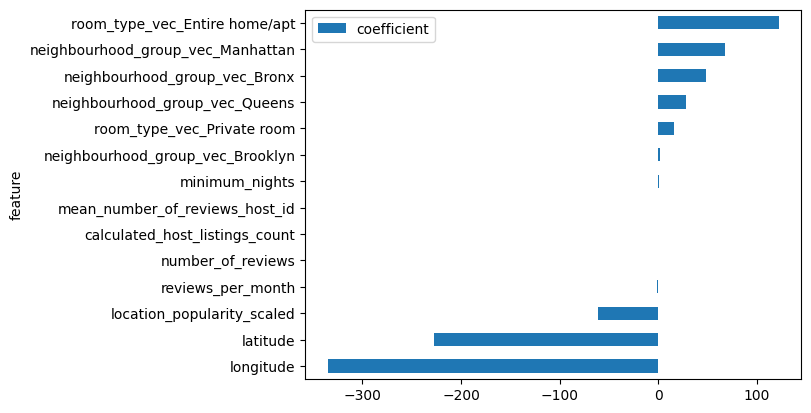

In [578]:
results.plot(x='feature', kind='barh').invert_yaxis()

In [579]:
# print the model training results using MAE (mean absolute error) & RMSE (root mean square error)
print("mae:", model.summary.meanAbsoluteError)
print("rmse:", model.summary.rootMeanSquaredError)

mae: 53.820809666589604
rmse: 87.19887689592606


In [580]:
# evaluate the model for the test set
for metric in ['mae', 'rmse']:
  evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=label_col, metricName=metric)
  score = evaluator.evaluate(predictions)
  print(metric+':', score)

mae: 53.9183806252561
rmse: 85.92729600982966


# Hands-on Exercise: PySpark Feature Engineering

# Stop PySpark Cluster

In [ ]:
# stop pyspark cluster in standalone mode (Driver & SparkContext)
spark.stop()

# Final Message

Congratulations if you reached the end of this Notebook successfully!

You should now know the basics of Spark Core and Spark SQL to work on Big Data. You know how to read, process, clean and enrich datasets for exploratory data analysis, machine learning modeling or create data products. Keep up the good work.